# Install Pygame and Atari, then update gym

In [ ]:
# Do not install Pygame directly
# Install it using gym[classic_control] for correct versioning

!pip install --upgrade gym
!pip install gym[classic_control,atari,accept-rom-license]
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 721 kB 6.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827650 sha256=3baa684e83b77a3aaab83a10085dec4c173307cd822efb2fad27b0a7b9a55373
  Stored in directory: /root/.cache/pip/wheels/17/79/65/7afedc162d858b02708a3b8f7a6dd5b1000dcd5b0f894f7cc1
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.3 MB 7.2 MB/s 
     |████████████████████████████████| 1.7 MB 81.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... d

# Function to display MP4 files inside Colab

In [ ]:
from IPython.display import HTML
from base64 import b64encode

def show_video(file_name):
    mp4 = open(file_name, "rb").read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
<video width=400 controls>
    <source src="%s" type="video/mp4">
</video>
""" % data_url)

# Imports

In [ ]:
import random
from collections import deque
import numpy as np

import gym
import ale_py

import torch
import torchinfo

import matplotlib.pyplot as plt
import seaborn as sns

# Changeable Settings

It was pointed out that Atari games are entirely dterministic. Thus, agents can achieve state of the art performance just by memorizing an optimal sequence of actions while entirely ignoring observations from the environment. To avoid this, we provide some additional constraints as follows: frameskip, and repeat_action.

Stochastic frame skipping will repeat an action for a specified number of frames. Sticky actions will also occasionally make a "button sticky" and hold the last action for an additional step.

Setting both of these values to 0.0 will make learning easier, but might make it trivial, so test with [0, 0.0] values, then move to [5, 0.25].

* difficulty - how hard the opponent is | range of [0, ..., 3]

* frameskip - how many frames to repeat an action | default of 5

* repeat_action - chance that the previous action is performed instead of the new action provided | default of 25%

/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (210, 160)
  logger.warn(


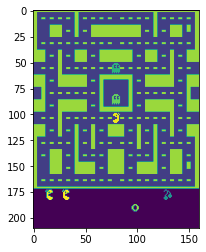

Height: 210, Width: 160


In [ ]:
environment = gym.make(
    
    id="ALE/MsPacman-v5",
    mode=0,
    obs_type="grayscale",
    full_action_space=False,
    render_mode="rgb_array",
    # changeable parameters
    frameskip=20,  # 5
    repeat_action_probability=0.0,  # 0.25
)

state, _ = environment.reset()
plt.imshow(state)
plt.show()
print(f"Height: {state.shape[0]}, Width: {state.shape[1]}")

In [ ]:
print(environment.observation_space.shape)


(210, 160)


You can notice that the image is grayscale (er, greenscale) and has a height of 210 pixels and width of 160 pixels. We also can see a score at the top and some decorative bars at the top and bottom.

The score and decorative bars do not add anything to our state, so we want to remove them as the score changes the image, but adds nothing.

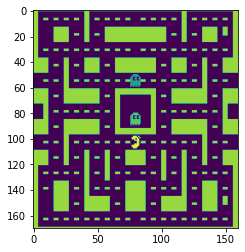

New Height: 170, New Width: 160


In [ ]:
def clean_image(image):
    return image[1:171, :] #found dimensions by messing with parameter

state, _ = environment.reset()
state = clean_image(state)
plt.imshow(state)
plt.show()
print(f"New Height: {state.shape[0]}, New Width: {state.shape[1]}")

We want to go a bit further and trim the state down to a 64x64 image. We also need to do some extra processing to get the state ready for PyTorch.

Old image size: (210, 160)
New image size: torch.Size([1, 64, 64])
Step: 14, Reward: 10.0
Step: 15, Reward: 20.0
Step: 16, Reward: 10.0
Step: 17, Reward: 20.0


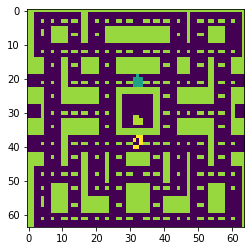

In [ ]:
# Optional - Modify the environment's step function so it cleans the state for us
environment = gym.make(
    id="ALE/MsPacman-v5",
    mode=0,
    obs_type="grayscale",
    full_action_space=False,
    render_mode="rgb_array",

    # changeable parameters
    difficulty=0,
    frameskip=20,  # 5
    repeat_action_probability=0.0,  # 0.25
)

def clean_image(image):
    image = image[1:171, :] #found dimensions by messing with parameter
    image = torch.tensor(image, dtype=torch.float)
    image = image[None, None, ...]
    image = torch.nn.functional.interpolate(image, size=(64, 64))
    image = image[0]
    return image

def new_step(step):
    def wrapper(action):
        state, reward, done, *info = step(action)
        state = clean_image(state)
        return state, reward, done, info
    return wrapper

def new_reset(reset):
    def wrapper():
        state, info = reset()
        state = clean_image(state)
        return state, info
    return wrapper

# Show the original image shape after a step
print(f"Old image size: {environment.reset()[0].shape}")

# Add our decorator to the step function
environment.step = new_step(environment.step)
environment.reset = new_reset(environment.reset)

# Notice the shape is now different (cleaned)
print(f"New image size: {environment.step(0)[0].shape}")
image1 = environment.step(0)[0].numpy()

image2 = environment.step(1)[0].numpy()
avg = (image1 + image2) / 2
# plt.imshow(avg[0])
# plt.imshow(image1[0])
plt.imshow(image1[0])
steps = 0
done = False
s, _ = environment.reset()
while not done:
    steps += 1
    s, r, done, *_ = environment.step(2)

    if steps == 250:
      pass
        # plt.imshow(s[0].numpy())
        # plt.show()

    if r != 0:
        print(f"Step: {steps}, Reward: {r}")

# plt.imshow(s[0].numpy())
# plt.show()


# Neural Network

We added a few extra layers to the neural network. They are Convolutional Layers.

Here are some great graphics on what convolutional filters do along with the settings
https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md

In [ ]:
class ConvolutionalNN(torch.nn.Module):
    def __init__(self):
        super(ConvolutionalNN, self).__init__()

        self.conv1 = torch.nn.Conv2d(
            in_channels=4,
            out_channels=16,
            kernel_size=(5, 5),
            stride=1,
            bias=False,
        )

        self.conv2 = torch.nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=(3, 3),
            stride=1,
            bias=False,
        )

        self.conv3 = torch.nn.Conv2d(
            in_channels=32,
            out_channels=32,
            kernel_size=(3, 3),
            stride=1,
            bias=False,
        )

        self.flatten = torch.nn.Flatten()

    def forward(self, x):
        x = self.conv1(x)
        x = torch.nn.functional.leaky_relu(x)

        x = self.conv2(x)
        x = torch.nn.functional.leaky_relu(x)

        x = self.conv3(x)
        x = torch.nn.functional.leaky_relu(x)

        x = self.flatten(x)
        return x


class DenseNN(torch.nn.Module):
    def __init__(self, input_features, action_space):
        super(DenseNN, self).__init__()

        self.linear1 = torch.nn.Linear(input_features, 32)
        self.linear2 = torch.nn.Linear(32, action_space)

    def forward(self, x):
        x = self.linear1(x)
        x = torch.nn.functional.leaky_relu(x)

        x = self.linear2(x)
        return x


class QualityNN(torch.nn.Module):
    def __init__(self, action_space):
        super(QualityNN, self).__init__()

        self.cnn = ConvolutionalNN()
        self.dnn = DenseNN(100352, action_space)

    def forward(self, x):
        x = self.cnn(x)
        x = self.dnn(x)
        return x

In [ ]:
test_model = QualityNN(action_space=5)
test_state = environment.reset()[0]
test_state = torch.cat((test_state, test_state, test_state, test_state))
batched_test_state = test_state.unsqueeze(0)

batched_qualities = test_model(batched_test_state)
qualities = batched_qualities[0]
action = torch.argmax(qualities)

print(f"Qualities: {qualities}")
print(f"Policy: We should greedily take action {action}")
print()

print(torchinfo.summary(test_model, input_size=(1, 4, 64, 64)))

Qualities: tensor([ 0.7038, -4.5138,  4.7770,  1.8309,  4.2177],
       grad_fn=<SelectBackward0>)
Policy: We should greedily take action 2

Layer (type:depth-idx)                   Output Shape              Param #
QualityNN                                [1, 5]                    --
├─ConvolutionalNN: 1-1                   [1, 100352]               --
│    └─Conv2d: 2-1                       [1, 16, 60, 60]           1,600
│    └─Conv2d: 2-2                       [1, 32, 58, 58]           4,608
│    └─Conv2d: 2-3                       [1, 32, 56, 56]           9,216
│    └─Flatten: 2-4                      [1, 100352]               --
├─DenseNN: 1-2                           [1, 5]                    --
│    └─Linear: 2-5                       [1, 32]                   3,211,296
│    └─Linear: 2-6                       [1, 5]                    165
Total params: 3,226,885
Trainable params: 3,226,885
Non-trainable params: 0
Total mult-adds (M): 53.37
Input size (MB): 0.07
Forward/back

# Memory Storage

In [ ]:
class Memory(object):
    def __init__(self, max_size=10000):
        self.memory = deque(maxlen=max_size)

    def push(self, element):
        self.memory.append(element)

    def get_batch(self, batch_size=64):
        if batch_size > len(self.memory):
            batch_size = len(self.memory)
        return random.sample(self.memory, batch_size)

    def __repr__(self):
        return f"Current elements in memory: {len(self.memory)}"

    def __len__(self):
        return len(self.memory)

# Agent

In [ ]:
class Agent(object):
    def __init__(self, environment):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model = QualityNN(action_space=5).to(self.device)
        self.target_model = QualityNN(action_space=5).to(self.device)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=3e-3)
        # change lr to 3e-4 if plateu

        self.decay = 0.995  # change to 0.995 if over 1000 epochs 
        self.randomness = 1.00
        self.min_randomness = 0.01

    def act(self, state):
        # move the state to a Torch Tensor and add a batch of size 1
        state = state.to(self.device).unsqueeze(0)

        qualities = self.model(state).cpu()
        qualities = qualities[0]

        if np.random.rand() <= self.randomness:
            action = np.random.randint(low=0, high=qualities.size(dim=0))
        else:
            action = torch.argmax(qualities).item()

        return action

    def update(self, memory_batch):
        states, next_states, actions, rewards = self.unpack_batch(memory_batch)

        old_targets = self.old_targets(states, actions)
        new_targets = self.new_targets(states, next_states, rewards, actions)
        loss = torch.nn.functional.smooth_l1_loss(old_targets, new_targets)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # return the loss for logging purposes
        return loss.item()

    def old_targets(self, states, actions):
        return self.model(states).gather(1, actions)

    # double DQN - change self.model to self.target_model
    def new_targets(self, states, next_states, rewards, actions):
        return rewards + torch.amax(self.target_model(next_states), dim=1, keepdim=True)

    def unpack_batch(self, batch):
        states, next_states, actions, rewards = zip(*batch)

        states = torch.stack(states).to(self.device)
        next_states = torch.stack(next_states).to(self.device)

        actions = torch.tensor(actions).long().unsqueeze(1).to(self.device)
        rewards = torch.tensor(rewards).float().unsqueeze(1).to(self.device)

        return states, next_states, actions, rewards

    # double DQN - update self.target_model.state_dict to equal self.model.state_dict
    def update_randomness(self):
        self.randomness *= self.decay
        self.randomness = max(self.randomness, self.min_randomness)
        self.target_model.state_dict = self.model.state_dict()


# TD Learning

In [ ]:
max_iteration = 2000
logging_iteration = 50
import imageio
import gc 
import time

# some logging values
score_logging = []
error_logging = []

# checkpoint loading
agent = Agent(environment)

# checkpoint = torch.load("/content/checkpoint.pth")
# print(f"Starting from iteration {checkpoint['iteration']}")

# agent.model.state_dict = checkpoint["model"]
# agent.optimizer.state_dict = checkpoint["optimizer"]
memory = Memory(max_size=10000)
state_stack = deque(maxlen=4)
totaltime = 0

for iteration in range(1, max_iteration + 1):
    done = False
    state, _ = environment.reset()
    state_stack.append(state)

    # some logging values
    wins = 0
    losses = 0
    score = 0

    # play (do nothing) for 3 frames so we can start frame stacking
    # option: take first frame and duplicate 3 times (4 frames total)
    for _ in range(3):
        state, *_ = environment.step(np.random.randint(5))
        state_stack.append(state)

    while not done:
        # Action 2 is up. Action 3 is down
        # Map NN action of 0->2 and action of 1->3
        action = agent.act(torch.cat(list(state_stack)))
        state, reward, done, *_ = environment.step(action)

        last_state_stack = torch.cat(list(state_stack))
        state_stack.append(state)
        next_state_stack = torch.cat(list(state_stack))
        
        score += reward
        # if reward == 0:
        #   reward = 9 #maybe 10? Still try to reward gather pellets, just not so much that the agent never tries to do more than grab a few. 
        memory.push(element=(
            last_state_stack,
            next_state_stack,
            action,
            reward,
        ))

        # "shock" the system with wins and losses
        if reward != 0:
            agent.update([memory.memory[-1]])

        # logging
       

    # make a few learning updates
    for _ in range(64):
        memory_batch = memory.get_batch(batch_size=32)
        error = agent.update(memory_batch)
    agent.update_randomness()

    # logging values and printing some
    error_logging.append(error)
    score_logging.append(score)
    score = 0

    gc.collect()
    if iteration % logging_iteration == 0:
        print(f"Iteration: {iteration}")
        print(f"  Moving-Average Wins   : {np.mean(np.array(score_logging)[-logging_iteration:])}")
        print(f"  Memory-Buffer Size    : {len(memory.memory)}")
        print(f"  Agent Randomness      : {agent.randomness:.3f}")
        print()
        #put checkpointing in here

        # checkpoint = {
        #     "model": agent.model.state_dict,
        #     "optimizer": agent.optimizer.state_dict,
        #     "iteration": iteration,
        # }
        
        checkpoint = {
            "model": agent.model.state_dict(),
            "optimizer": agent.optimizer.state_dict(),
            "iteration": iteration,
        }
        #torch.save(checkpoint, f"./{str(iteration)}_checkpoint.pth")
        torch.save(checkpoint, "./checkpoint.pth")

# print ("Average Episode Time:" , totaltime/max_iteration)

Iteration: 50
  Moving-Average Wins   : 211.8
  Memory-Buffer Size    : 10000
  Agent Randomness      : 0.778

Iteration: 100
  Moving-Average Wins   : 317.2
  Memory-Buffer Size    : 10000
  Agent Randomness      : 0.606

Iteration: 150
  Moving-Average Wins   : 356.2
  Memory-Buffer Size    : 10000
  Agent Randomness      : 0.471

Iteration: 200
  Moving-Average Wins   : 440.4
  Memory-Buffer Size    : 10000
  Agent Randomness      : 0.367

Iteration: 250
  Moving-Average Wins   : 455.0
  Memory-Buffer Size    : 10000
  Agent Randomness      : 0.286

Iteration: 300
  Moving-Average Wins   : 412.2
  Memory-Buffer Size    : 10000
  Agent Randomness      : 0.222

Iteration: 350
  Moving-Average Wins   : 375.6
  Memory-Buffer Size    : 10000
  Agent Randomness      : 0.173

Iteration: 400
  Moving-Average Wins   : 416.8
  Memory-Buffer Size    : 10000
  Agent Randomness      : 0.135

Iteration: 450
  Moving-Average Wins   : 493.4
  Memory-Buffer Size    : 10000
  Agent Randomness      : 

In [ ]:
# checkpoint loading
# agent = Agent(environment)

# checkpoint = torch.load("/content/checkpoint2800.pth")
# print(f"Starting from iteration {checkpoint['iteration']}")

# agent.model.state_dict = checkpoint["model"]
# agent.optimizer.state_dict = checkpoint["optimizer"]

# resume training
# ...
from google.colab import files

files.download('/content/checkpoint.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Plotting and results

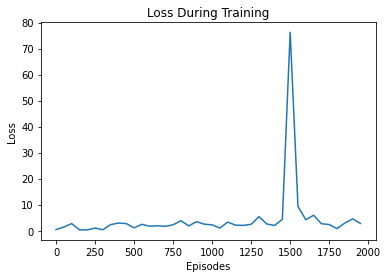

In [ ]:
x = np.arange(0, len(error_logging), logging_iteration)
y = np.add.reduceat(error_logging, x) / logging_iteration

plt.plot(x, y)
plt.title("Loss During Training")
plt.xlabel("Episodes")
plt.ylabel("Loss")
plt.show()

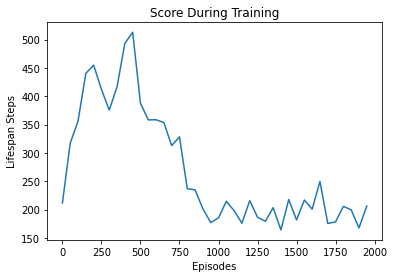

In [ ]:
score = np.array(score_logging)

x = np.arange(0, len(score), logging_iteration)
y = np.add.reduceat(score, x) / logging_iteration

sns.lineplot(x=x, y=y)
plt.title("Score During Training")
plt.xlabel("Episodes")
plt.ylabel("Lifespan Steps")
plt.show()

# Show some saved videos

In [ ]:
environment = gym.make(
    id="ALE/MsPacman-v5",
    mode=0,
    obs_type="grayscale",
    full_action_space=False,
    render_mode="rgb_array",

    # changeable parameters
    difficulty=0,
    frameskip=1,  # 5
    repeat_action_probability=0.0,  # 0.25
)

environment.step = new_step(environment.step)
environment.reset = new_reset(environment.reset)

state_stack = deque(maxlen=4)

done = False
state, _ = environment.reset()
state_stack.append(state)

frames = [environment.render()]

# play (do nothing) for 2 frames so we can start frame stacking
for _ in range(3):
    state, *_ = environment.step(np.random.randint(5))
    state_stack.append(state)
    frames.append(environment.render())

while not done:
    # Action 2 is up. Action 3 is down
    # Map NN action of 0->2 and action of 1->3
    action = agent.act(torch.cat(list(state_stack)))
    state, reward, done, *_ = environment.step(action)
    state_stack.append(state)

    frames.append(environment.render())


/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (210, 160)
  logger.warn(
/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


In [ ]:
import imageio

imageio.mimsave("goodgame.gif", frames, format="GIF", fps=60)   